In [29]:
from sklearn import svm
import matplotlib.pyplot as plt
from Haldane_anis_supervise_class import *
from partial import *

In [ ]:
L = 51  # number of particles must be odd
keep = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] # keep the part that we wanna do partial trace over that
bond = 10  # reasonable amount
p = partial(L, keep, bond)

In [31]:
dataset = p.generate_dataset()
partial_density_matrix_train, partial_density_matrix_test = p.partial_density_matrix()
kernel_partial_train = p.gram_train_partial()
kernel_partial_test = p.gram_test_partial()

/home/mehran/TN_QML/lib/python3.12/site-packages/quimb/core.py:45: UserWarning: 'NUMBA_NUM_THREADS' has been set elsewhere and doesn't match the value 'quimb' has tried to set - 4 vs 1.
  warnings.warn(
/home/mehran/TN_QML/lib/python3.12/site-packages/quimb/core.py:45: UserWarning: 'NUMBA_NUM_THREADS' has been set elsewhere and doesn't match the value 'quimb' has tried to set - 4 vs 1.
  warnings.warn(
/home/mehran/TN_QML/lib/python3.12/site-packages/quimb/core.py:45: UserWarning: 'NUMBA_NUM_THREADS' has been set elsewhere and doesn't match the value 'quimb' has tried to set - 4 vs 1.
  warnings.warn(
/home/mehran/TN_QML/lib/python3.12/site-packages/quimb/core.py:45: UserWarning: 'NUMBA_NUM_THREADS' has been set elsewhere and doesn't match the value 'quimb' has tried to set - 4 vs 1.
  warnings.warn(
/home/mehran/TN_QML/lib/python3.12/site-packages/quimb/core.py:45: UserWarning: 'NUMBA_NUM_THREADS' has been set elsewhere and doesn't match the value 'quimb' has tried to set - 4 vs 1.
  

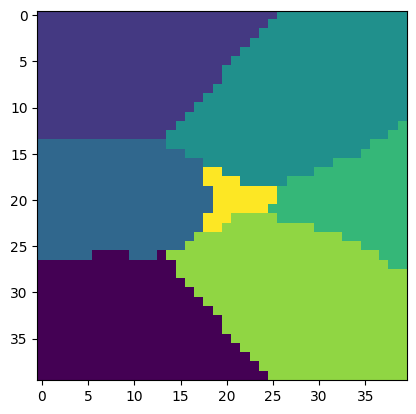

In [32]:
clf = svm.SVC(kernel='precomputed')
kernel_train = kernel_partial_train
kernel_test = kernel_partial_test
y = dataset[0][1]
clf.fit(kernel_train, y) 
y_pred = clf.predict(kernel_test)
plt.imshow(y_pred.reshape(40,40))
plt.savefig(f'result for DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()